In [82]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline


In [83]:
spark = SparkSession.builder.appName("WaterPotabilityPrediction").getOrCreate()

In [84]:
data = spark.read.csv("Water1.csv", header=True, inferSchema=True)

In [85]:
columns_to_fill = ['ph']

medians = {col: data.approxQuantile(col, [0.5], 0.0)[0] for col in columns_to_fill}


for col, median in medians.items():
    data = data.na.fill({col: median})


data.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|                ph|          Hardness|           Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|         Potability|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|              2293|              2293|             2293|              2293|              2293|              2293|              2293|              2293|              2293|               2293|
|   mean| 7.086923773484187|196.39033467318723|22074.33533378741|  7.13298722773223|333.39334730577684|425.45570192935264|14.229174077558303| 66.49951785248768|3.9671531697581806|0.39031836022677713|


In [86]:
from pyspark.sql.functions import col
data = data.withColumn('Hardness_Solids', col('hardness') * col('solids'))
data.show()
data.describe().show()

+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+
|               ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|   Hardness_Solids|
+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+
|7.080794504276835|219.67426193471448|22210.613083285505| 5.875041088125667| 333.7757766108135| 398.5177031387568|11.502315629592148|112.41221043181724|2.9942592099578635|         0| 4879100.036188256|
|6.783888467541533|193.65358060131555| 13677.10644058598| 5.171453573375093| 323.7286632332804| 477.8546872578033|15.056064094821464| 66.39629294676803| 3.250022229204365|         0|2648620.63

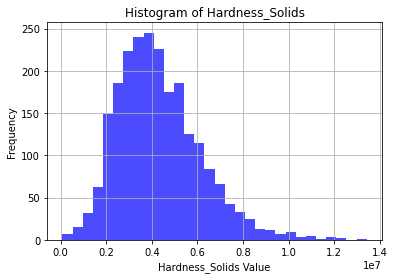

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

hardness_solids_pdf = data.select("Hardness_Solids").toPandas()
plt.hist(hardness_solids_pdf['Hardness_Solids'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Hardness_Solids')
plt.xlabel('Hardness_Solids Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [88]:
all_columns = data.columns
# The first DataFrame contains the first five variables
first_five_columns = all_columns[:5]  # set columns is 5
df_first_five = data.select(first_five_columns)

# The second DataFrame contains the last six variables
last_six_columns = all_columns[-6:]  # set columns is 6
df_last_six = data.select(last_six_columns)
# print first set
print("First DataFrame with first five columns:")
df_first_five.show(5)

# print second set
print("Second DataFrame with last six columns:")
df_last_six.show(5)

First DataFrame with first five columns:
+-----------------+------------------+------------------+-----------------+-----------------+
|               ph|          Hardness|            Solids|      Chloramines|          Sulfate|
+-----------------+------------------+------------------+-----------------+-----------------+
|7.080794504276835|219.67426193471448|22210.613083285505|5.875041088125667|333.7757766108135|
|6.783888467541533|193.65358060131555| 13677.10644058598|5.171453573375093|323.7286632332804|
|6.010617576533585|184.55858174244537|15940.573270538474|8.165222040842318|421.4860891671315|
|8.097453770731768| 218.9924361418924| 18112.28444651079|6.196947393934283|333.7757766108135|
|      8.072612403| 210.2697797493537| 16843.36392740596|8.793458647829397|359.5161693303079|
+-----------------+------------------+------------------+-----------------+-----------------+
only showing top 5 rows

Second DataFrame with last six columns:
+-----------------+------------------+----------

In [89]:
from pyspark.sql.functions import monotonically_increasing_id

# Add row indexes to two DataFrames
df_first_five = df_first_five.withColumn("row_id", monotonically_increasing_id())
df_last_six = df_last_six.withColumn("row_id", monotonically_increasing_id())
# Merge DataFrame by row index
df_merged = df_first_five.join(df_last_six, "row_id", "inner").drop("row_id")

df_merged.show(5)

+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+----------+------------------+
|               ph|          Hardness|            Solids|      Chloramines|          Sulfate|     Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|   Hardness_Solids|
+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+----------+------------------+
|7.080794504276835|219.67426193471448|22210.613083285505|5.875041088125667|333.7757766108135|398.5177031387568|11.502315629592148|112.41221043181724|2.9942592099578635|         0| 4879100.036188256|
|6.783888467541533|193.65358060131555| 13677.10644058598|5.171453573375093|323.7286632332804|477.8546872578033|15.056064094821464| 66.39629294676803| 3.250022229204365|         0|2648620.6344847893|
|6.01

In [90]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log1p
from pyspark.sql.types import IntegerType, DoubleType
# Identify numeric columns
numeric_cols = [f.name for f in data.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType))]
# Apply a logarithmic transformation to each numeric column
for col_name in numeric_cols:
    data = data.withColumn(f"{col_name}_log", log1p(col(col_name)))
data.show()
print(data.columns)

+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|               ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|   Hardness_Solids|            ph_log|      Hardness_log|        Solids_log|   Chloramines_log|       Sulfate_log|  Conductivity_log|Organic_carbon_log|Trihalomethanes_log|     Turbidity_log|    Potability_log|Hardness_Solids_log|
+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---

In [91]:
data1, _ = data.randomSplit([0.8, 0.2], seed=42)
data1.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|summary|                ph|          Hardness|           Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|         Potability|     Hardness_Solids|             ph_log|      Hardness_log|         Solids_log|    Chloramines_log|      Sulfate_log|   Conductivity_log| Organic_carbon_log|Trihalomethanes_log|      Turbidity_log|     Potability_log|Hardness_Solids_log|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+--

In [92]:
data1 = data1.drop('Potability_log')
data1.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|     Hardness_Solids|             ph_log|      Hardness_log|        Solids_log|   Chloramines_log|       Sulfate_log|  Conductivity_log|Organic_carbon_log|Trihalomethanes_log|     Turbidity_log|Hardness_Solids_log|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+

In [93]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="Potability", outputCol="label")

assembler = VectorAssembler(inputCols=[c for c in data1.columns if c != 'Potability'], outputCol="features")

pipeline = Pipeline(stages=[indexer, assembler])
data1_transformed = pipeline.fit(data1).transform(data1)


In [94]:
from pyspark.ml.classification import RandomForestClassifier

# Creating a Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20)

model = rf.fit(data1_transformed)

importances = model.featureImportances

Feature Importances:
Sulfate_log: 0.1502479926680869
Sulfate: 0.10275512747429456
ph: 0.09049722655400233
Hardness: 0.08013522797300476
ph_log: 0.06480136719972057
Chloramines: 0.05459204054309309
Solids: 0.05065409285410421
Hardness_log: 0.05027288174932938
Solids_log: 0.0469397475644773
Chloramines_log: 0.04348616136481619
Turbidity: 0.04064239281810452
Hardness_Solids_log: 0.03573091647922187
Conductivity_log: 0.028361194125556134
Hardness_Solids: 0.024465852703800983
Organic_carbon_log: 0.024166352387699853
Conductivity: 0.02384021299665307
Trihalomethanes_log: 0.023795354628205593
Organic_carbon: 0.022748573522402185
Trihalomethanes: 0.022725739343014258
Turbidity_log: 0.019141545050412122


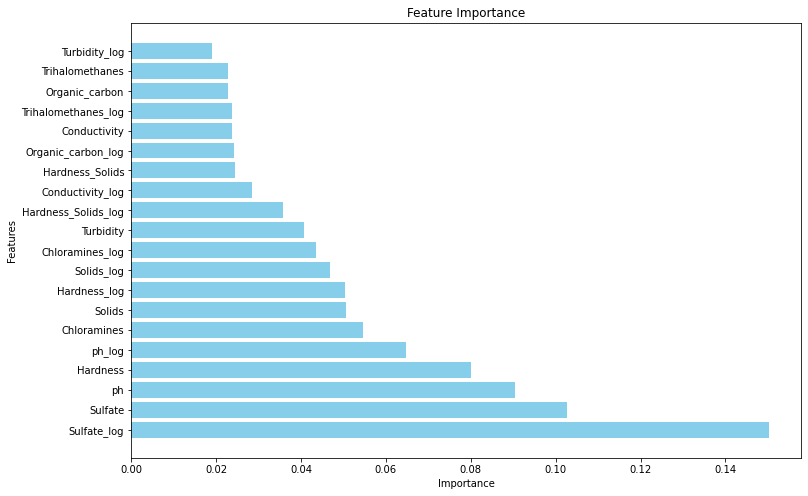

In [95]:
feature_names = [c for c in data1.columns if c != 'Potability']

print("Feature Importances:")
sorted_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for name, imp in sorted_importances:
    print(f"{name}: {imp}")
    
import matplotlib.pyplot as plt

feature_names, importances = zip(*sorted_importances)

plt.figure(figsize=(12, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


In [96]:
data1 = data1.drop("Turbidity_log", "Trihalomethanes", "Organic_carbon")


data1.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|         Turbidity|Potability|     Hardness_Solids|             ph_log|      Hardness_log|        Solids_log|   Chloramines_log|       Sulfate_log|  Conductivity_log|Organic_carbon_log|Trihalomethanes_log|Hardness_Solids_log|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------